In [1]:
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from PIL import Image, ImageDraw
import PIL
import os
import pandas as pd
import numpy as np
import typing
import torch

In [15]:
def gather_data(path: str) -> pd.DataFrame:
    image_ids = []
    bbox_left = []
    bbox_top = []
    bbox_right = []
    bbox_bottom = []
    classes = []

    for item in os.listdir(path + "/image"): # look at every image in path
        image_id = item.split(".")[0] # split on file extension and just get id
        
        with open(f"{path}/label/{image_id}.txt", "r") as f:
            for line in f.readlines():
                split_line = line.split(" ")
                
                image_ids.append(image_id)

                # each bbox is defined as (class left top right bottom) as a new line in the corresponding .txt file

                classes.append(split_line[0].strip())
                bbox_left.append(split_line[1].strip())
                bbox_top.append(split_line[2].strip())
                bbox_right.append(split_line[3].strip())
                bbox_bottom.append(split_line[4].strip("\n"))

    df = pd.DataFrame(data={
        "image_id": image_ids,
        "bbox_left": bbox_left,
        "bbox_top": bbox_top,
        "bbox_right": bbox_right,
        "bbox_bottom": bbox_bottom,
        "class": classes
    })

    return df

In [16]:
df = gather_data("crowd4access-images/crowd4access-images/trainval")
df.head()

,image_id,bbox_left,bbox_top,bbox_right,bbox_bottom,class
0,jiYLJwXmVXuZKQA9N6O7v3,515,288,835,438,tactile_surface
1,0q6mFPlnqbVkUG1azCIcnA,447,431,685,491,tactile_surface
2,0q6mFPlnqbVkUG1azCIcnA,719,412,819,432,tactile_surface
3,hbcZ1FfLcwudenW4PLHJ9h,731,288,1017,431,tactile_surface
4,nA4vzxw0BdqNTRHk1G9Qjw,456,277,642,336,tactile_surface


In [17]:
def draw_example(index: int) -> Image:
    filename = df["image_id"][index]
    image = Image.open(f"crowd4access-images/crowd4access-images/trainval/image/{filename}.jpg")

    draw = ImageDraw.Draw(image, "RGBA")

    left = float(df["bbox_left"][index])
    top = float(df["bbox_top"][index])
    right = float(df["bbox_right"][index])
    bottom = float(df["bbox_bottom"][index])

    draw.rectangle([(right, top), (left, bottom)])
    draw.text(
        (100, 100), 
        f"{str(left)}\n{str(top)}\n{str(right)}\n{str(bottom)}\n", 
        fill="red",
        size=24)

    return image

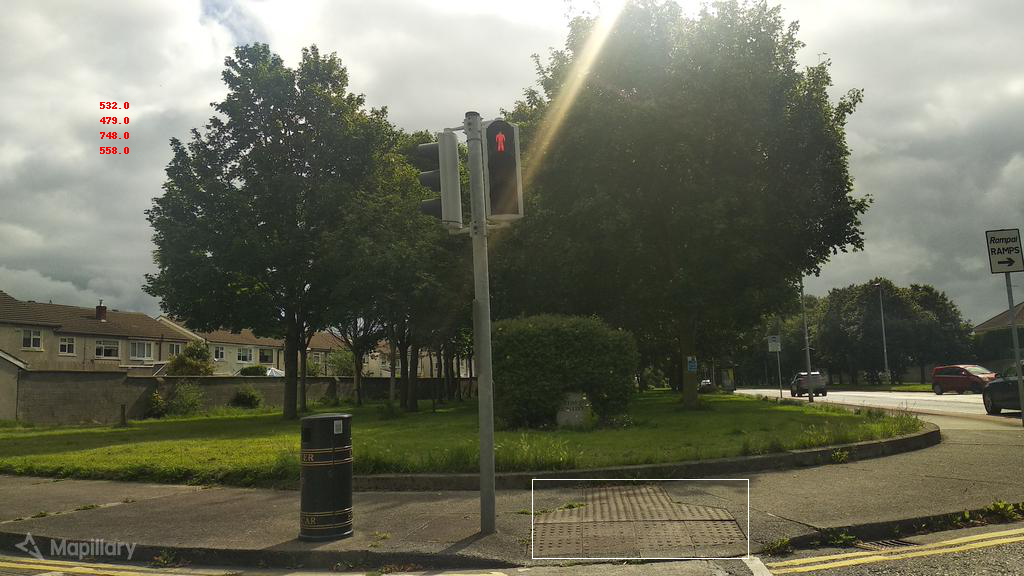

In [18]:
draw_example(np.random.randint(0, df.shape[0]))

For the model I want to use (facebook/detr-resnet-50) from Hugging Face, it requires the annotations to be in the format:
```
{"image_id": int,
"annotations": List[Dict]}
```
with each Dict being a COCO object annotation

In [2]:
def convert_bbox_definition(left: int, top: int, right: int, bottom: int) -> list:
    '''
    Converts bounding box definition from:
    
    `class_name top_left_x top_left_y bottom_right_x bottom_right_y`

    to the proper COCO formatting defined as:

    `top_left_x top_left_y width height`

    '''
    top_left_x = left
    top_left_y = top
    width = right - left
    height = bottom - top

    bbox = [top_left_x, top_left_y, width, height]
    return bbox

In [12]:
def convert2coco(path: str) -> dict:
    '''
    Creates the correct label formatting for the model to train on defined as a dictionary with keys `image_id` and `annotations` where `annotations` is a list of dictionaries with each dictionary being a COCO object annotation
    '''

    d = {
        "info": {
            "description": "Tactile Paving Dataset from Crowd4Access",
            "year": 2022
        },

        "licenses": [
            {
                "id": 0,
                "name": "Attribution-ShareAlike 4.0 International",
                "url": "https://creativecommons.org/licenses/by-sa/4.0/legalcode"
            }
        ],

        "images": [],

        "annotations": [],

        "categories": [
            {
                "id": 0,
                "name": "tactile_paving",
                "supercategory": "tactile_paving"
            }
        ]
    }

    i = 0 # counter for creating new image ids
    j = 0 # counter for annotation ids

    for item in os.listdir(path + "/image"): # look at every image in path
        
        filename = item.split(".")[0] # split on file extension and just get id
        
        with open(f"{path}/label/{filename}.txt", "r") as f:
            # ANNOTATIONS
            for line in f.readlines():
                split_line = line.split(" ")
                
                # each bbox is defined as (class left top right bottom) as a new line in the corresponding .txt file

                image_class = split_line[0].strip()
                bbox_left = int(split_line[1].strip())
                bbox_top = int(split_line[2].strip())
                bbox_right = int(split_line[3].strip())
                bbox_bottom = int(split_line[4].strip("\n"))

                new_bbox = convert_bbox_definition(
                    bbox_left,
                    bbox_top,
                    bbox_right,
                    bbox_bottom
                )

                unique_coco_annotation = {
                    "image_id": i,
                    "bbox": new_bbox,
                    "id": j,
                    "category_id": 0,
                    "segmentation": [],
                    "area": 0,
                    "iscrowd": 0
                }

                d["annotations"].append(unique_coco_annotation)
                
                j += 1

        # IMAGES
        image = Image.open(path + "/image/" + item)
        height = image.size[1]
        width = image.size[0]
        id = i
        license = 0
        file_name = item

        unique_coco_image = {
            "id": id,
            "file_name": file_name,
            "width": width,
            "height": height,
            "license": license
        }

        d["images"].append(unique_coco_image)

        i += 1
    return d

In [13]:
data_as_coco = convert2coco("crowd4access-images/crowd4access-images/trainval")

In [14]:
import json

with open("crowd4access-images/crowd4access-images/trainval/image/custom_train.json", "w") as f:
    json.dump(data_as_coco, f)

# Make a HF Dataset

In [6]:
import torchvision

In [10]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_test.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [15]:
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder='crowd4access-images/crowd4access-images/trainval/image', feature_extractor=feature_extractor)
# test_dataset = CocoDetection(img_folder='crowd4access-images/crowd4access-images/test/image', feature_extractor=feature_extractor, train=False)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


Image n°1124


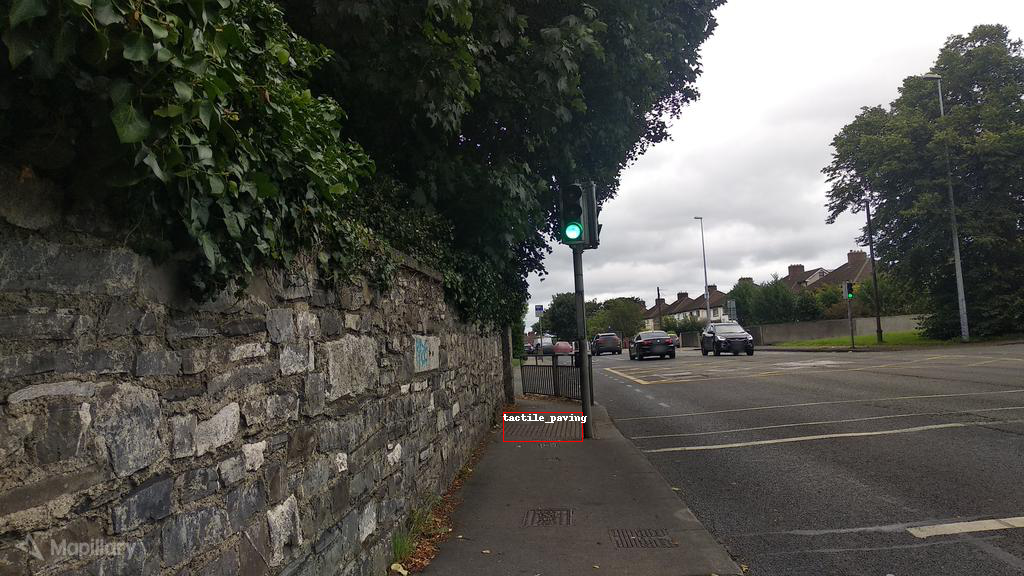

In [23]:
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('crowd4access-images/crowd4access-images/trainval/image', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image